<a href="https://colab.research.google.com/github/Callum-pb/python_projects/blob/master/weight_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np


In [0]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1KYiph71L7fyHS01_X08fKKEb_9Ev3RCOeeeEkYQ8nFY/edit')

In [0]:
sheet = wb.worksheet('Weight Log')

In [0]:
data = sheet.get_all_values()

In [0]:
#Create df from CSV and view top of CSV imported
weights = pd.DataFrame(data)
print('Top of CSV')
print(weights.head(10))
#Drop crap at top of page to leave table
weights = weights.iloc[6:,0:2]
print('\nTop of data table')
print(weights.head(10))
#Column headers
weights_heads = weights.iloc[0].values
print('\nHeaders:')
print(weights_heads)
weights_heads[1] = 'WeightKG'
print('\n\n')
#Set column headers and remove first row, so df is just data. Also reindex df
weights.columns = weights_heads
weights = weights.iloc[1:]
weights.reset_index(drop=True,inplace=True)

print(weights.head(10))

Top of CSV
                0            1          2  ...            4      5      6
0      04/06/2020           kg        lbs  ...                  kg    lbs
1    Start Weight        130.9      288.0  ...  Goal Weight    100    220
2  Current Weight       112.10      246.6  ...    Remaining  12.10  26.62
3     Weight Lost        18.80       41.4  ...                           
4                                          ...                           
5                                          ...                           
6            Date  Weight (kg)  7-day Avg  ...                           
7      12/05/2019        130.9          -  ...                           
8      13/05/2019        127.8          -  ...                           
9      14/05/2019        127.8          -  ...                           

[10 rows x 7 columns]

Top of data table
             0            1
6         Date  Weight (kg)
7   12/05/2019        130.9
8   13/05/2019        127.8
9   14/05/2019       

In [0]:
#Check data types
print(weights.dtypes)
print('\n\n')

##Decided dates should just be index
#weights.set_index(weights['Date'],inplace=True)
#Convert Date to datetime, weight to float
weights['Date'] = pd.to_datetime(weights.Date,dayfirst=True)
weights['WeightKG'] = pd.to_numeric(weights.WeightKG)

#Decided dates should just be index
#weights.set_index('Date',inplace=True)

print(weights.dtypes)

Date        datetime64[ns]
WeightKG           float64
dtype: object



Date        datetime64[ns]
WeightKG           float64
dtype: object


In [0]:
weights.sample(20)

,Date,WeightKG
251,2020-01-18,116.75
368,2020-05-14,115.00
211,2019-12-09,NaN
77,2019-07-28,128.40
32,2019-06-13,128.50
12,2019-05-24,128.50
218,2019-12-16,NaN
355,2020-05-01,117.05
367,2020-05-13,114.15
210,2019-12-08,NaN


In [0]:
#Check date entries in range
print(weights.Date.min())
print(weights.Date.max())
#Dates are fine, I could drop the last 4 days which are ahead of today, but when plotting I'd like to leave NaN values empty anyways

2019-05-12 00:00:00
2020-06-06 00:00:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


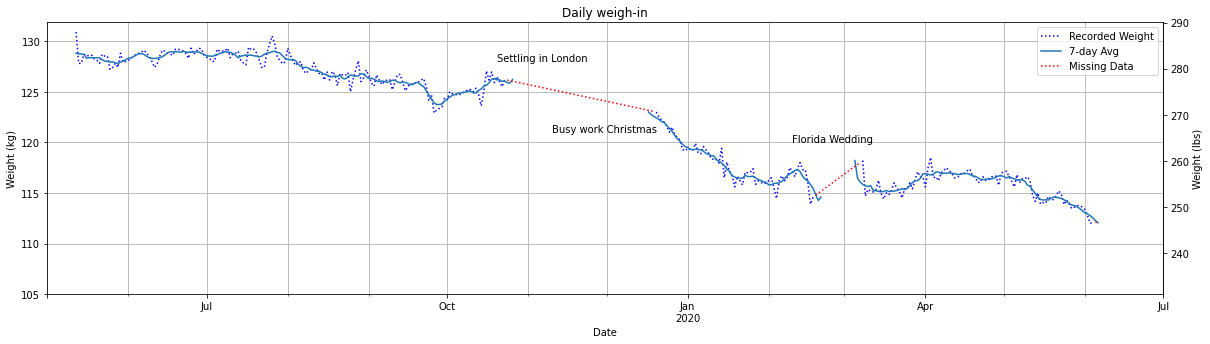

In [0]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Daily weigh-in')
ax.set_ylabel('Weight (kg)')
ax.set_xlabel('Date')

#Add 7-day moving average column to df and then add to plot
weights['MovAvg'] = weights.WeightKG.rolling(min_periods=1,window=7,center=True).mean()
#seperate dotted plot for interpolated missing data - could add to either series but I'd like to show that it is interpolacted and not primary data
weights['Interp'] = weights['WeightKG'].interpolate(method='linear',limit_direction='forward') #New col, linear interpolate from begingin all missing data
weights['Interp'][weights.WeightKG.notna()] = np.nan #Create boolean showing where the not-null values are in original weights col, then set those rows in interp col to NAN so they don't show on plot

#Plots
weights.plot(x='Date',y='WeightKG',ax=ax, grid=True,style='b:',label='Recorded Weight') #Recored weights
weights.plot(x='Date',y='MovAvg',ax=ax,label = '7-day Avg') #7-day moving average - centered
weights.plot(x='Date',y='Interp',ax=ax,style='r:',label = 'Missing Data') #Interpolated data


#Extende axes to show perspective
ax.set_xlim(pd.Timestamp('2019-05-01'),pd.Timestamp('2020-07-01'))
ax.set_ylim(bottom=105)

#Annotate Graph
ax.annotate('Settling in London',('2019-10-20',128))
ax.annotate('Busy work Christmas',('2019-11-10',121))
ax.annotate('Florida Wedding',('2020-02-10',120))

#Add second vertical axis to show lbs
def KGtoLBS(x):
  return 2.2*x

def LBStoKG(x):
  return x/2.2

secaxy = ax.secondary_yaxis('right', functions=(KGtoLBS, LBStoKG))
secaxy.set_ylabel('Weight (lbs)')

#Add grid and ticks
ax
ax.grid(b=True,which='both')

plt.show()


In [0]:
fig.savefig('Weight loss so far')

In [0]:
weights.Date[0].day - 10

2